In [8]:
 #تثبيت المكتبات
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [9]:
#تحميل ملف ال cvs
!gdown --id 1ISNAPvxCQd7TSCmRHxJSRLrMfMFs5iT5
df = pd.read_csv('mnist_test.csv')

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:139: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ISNAPvxCQd7TSCmRHxJSRLrMfMFs5iT5
To: /content/mnist_test.csv
100% 18.3M/18.3M [00:00<00:00, 36.2MB/s]


/tmp/ipython-input-1863251267.py:3: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262

In [10]:
# التحقق من عدد الصور، عدد الفئات، قبل التدريب
df.info()
print("عدد الصور:", len(df))
print("عدد الفئات:", df['label'].nunique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10001 entries, 0 to 10000
Columns: 785 entries, label to pixel784
dtypes: object(785)
memory usage: 59.9+ MB
عدد الصور: 10001
عدد الفئات: 21


In [11]:
# عدد القيم المفقودة في كل عمود
print(df.isnull().sum())
print("إجمالي القيم المفقودة:", df.isnull().sum().sum())


label       0
pixel1      0
pixel2      0
pixel3      0
pixel4      0
           ..
pixel780    0
pixel781    0
pixel782    0
pixel783    0
pixel784    0
Length: 785, dtype: int64
إجمالي القيم المفقودة: 0


In [12]:
#  وعرض اول خمس صفوف
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,label,1x1,1x2,1x3,1x4,1x5,1x6,1x7,1x8,1x9,...,28x19,28x20,28x21,28x22,28x23,28x24,28x25,28x26,28x27,28x28
1,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:

# حوّل كل الأعمدة من pixel1 إلى pixel784 إلى أرقام
for col in df.columns[1:]:  # استثناء العمود الأول "label"
    df[col] = pd.to_numeric(df[col], errors='coerce')

# الآن احسب أكبر وأصغر قيمة من الأعمدة الرقمية
numeric_df = df.select_dtypes(include=[np.number])
print("أكبر قيمة:", numeric_df.max().max())
print("أصغر قيمة:", numeric_df.min().min())



أكبر قيمة: 255.0
أصغر قيمة: 0.0


In [14]:
#  عرض عدد الصفوف والاعمدة
df.shape

(10001, 785)

In [15]:
# تأكد أن العمود label رقمي قبل الحساب
df['label'] = pd.to_numeric(df['label'], errors='coerce').dropna().astype(int)

# الآن احسب عدد العينات لكل فئة
class_counts = df['label'].value_counts().sort_index()

print(class_counts)

label
0.0     980
1.0    1135
2.0    1032
3.0    1010
4.0     982
5.0     892
6.0     958
7.0    1028
8.0     974
9.0    1009
Name: count, dtype: int64


In [16]:
# تحويل العمود إلى أرقام بشكل آمن، مع تحويل أي قيمة غير رقمية إلى NaN
df["label"] = pd.to_numeric(df["label"], errors='coerce')

# حذف أي صف يحتوي على NaN في عمود 'label' من DataFrame بأكمله وإنشاء نسخة جديدة
df = df.dropna(subset=["label"]).copy()

# تحويل عمود 'label' إلى عدد صحيح
df["label"] = df["label"].astype(int)

# فصل البيانات
X = df.drop("label", axis=1)
y = df["label"]

In [17]:
# تقسيم البيانات إلى مجموعات تدريب، تحقق، واختبار
#  فصل 70% للتدريب و30% مؤقت (للاحق تقسيمه للتحقق والاختبار)
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42, stratify=y
)
# تقسيم الـ30% المؤقتة إلى 15% تحقق و15% اختبار
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# طباعة الأحجام للتأكد
print("Training set:", X_train.shape, y_train.shape)
print("Validation set:", X_val.shape, y_val.shape)
print("Test set:", X_test.shape, y_test.shape)


Training set: (7000, 784) (7000,)
Validation set: (1500, 784) (1500,)
Test set: (1500, 784) (1500,)


In [18]:
#التأكد من عمود الأرقام لن يتأثر بال normalization
print(y.head(10))


1     7
2     2
3     1
4     0
5     4
6     1
7     4
8     9
9     5
10    9
Name: label, dtype: int64


In [19]:
# التطبيع لتكون القيم بين 0 و 1
X_train = X_train / 255
X_val   = X_val / 255
X_test  = X_test / 255

# التحقق من نطاق القيم بعد التطبيع
print("Training set pixel range: Min =", X_train.min().min(), "Max =", X_train.max().max())
print("Validation set pixel range: Min =", X_val.min().min(), "Max =", X_val.max().max())
print("Test set pixel range: Min =", X_test.min().min(), "Max =", X_test.max().max())

Training set pixel range: Min = 0.0 Max = 1.0
Validation set pixel range: Min = 0.0 Max = 1.0
Test set pixel range: Min = 0.0 Max = 1.0


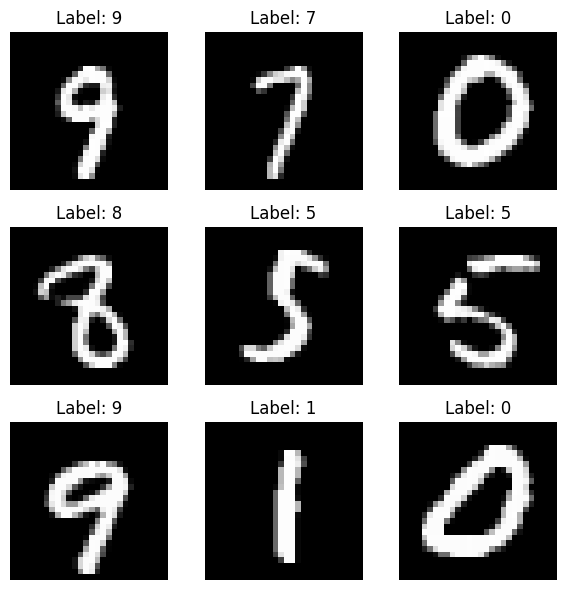

In [20]:
# عرض 9 صور من بيانات التدريب
plt.figure(figsize=(6,6))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train.iloc[i].values.reshape(28,28), cmap='gray')
    plt.title(f"Label: {y_train.iloc[i]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
#استيراد النموذج
from sklearn.linear_model import LogisticRegression

In [22]:

#انشاء النموذج
log_model = LogisticRegression(max_iter=1000)

In [23]:
from sklearn.preprocessing import StandardScaler

# إنشاء الكائن
scaler = StandardScaler()

# تدريب الـ scaler على بيانات التدريب وتحويلها
X_train_scaled = scaler.fit_transform(X_train)

# تحويل بيانات الفاليديشن والاختبار بنفس الـ scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# الآن تقدر تدرب النموذج
log_model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000)

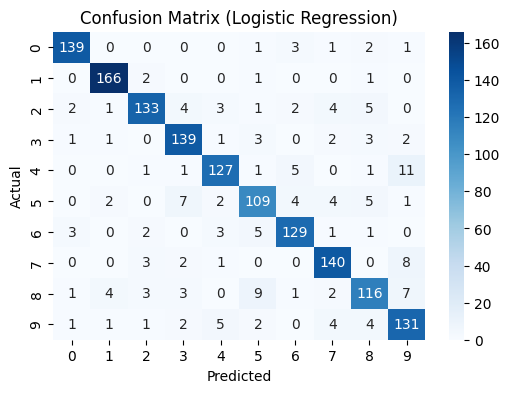

In [24]:
# التنبؤ بالقيم على مجموعة الاختبار باستخدام نموذج الانحدار اللوجستي
y_pred_log = log_model.predict(X_test_scaled)
# إنشاء رسم لمصفوفة الالتباس
plt.figure(figsize=(6,4))
cm_log = confusion_matrix(y_test, y_pred_log)
# رسم مصفوفة الالتباس باستخدام خريطة ألوان (Heatmap)
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Logistic Regression)")
plt.show()

In [25]:
# الحصول على التوقعات من النموذج اللوجستي
y_pred_log = log_model.predict(X_test_scaled)

# التقييم
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred_log))
print("Confusion Matrix (Logistic Regression):\n", confusion_matrix(y_test, y_pred_log))
print("\nClassification Report (Logistic Regression):\n", classification_report(y_test, y_pred_log))


Accuracy (Logistic Regression): 0.886
Confusion Matrix (Logistic Regression):
 [[139   0   0   0   0   1   3   1   2   1]
 [  0 166   2   0   0   1   0   0   1   0]
 [  2   1 133   4   3   1   2   4   5   0]
 [  1   1   0 139   1   3   0   2   3   2]
 [  0   0   1   1 127   1   5   0   1  11]
 [  0   2   0   7   2 109   4   4   5   1]
 [  3   0   2   0   3   5 129   1   1   0]
 [  0   0   3   2   1   0   0 140   0   8]
 [  1   4   3   3   0   9   1   2 116   7]
 [  1   1   1   2   5   2   0   4   4 131]]

Classification Report (Logistic Regression):
               precision    recall  f1-score   support

           0       0.95      0.95      0.95       147
           1       0.95      0.98      0.96       170
           2       0.92      0.86      0.89       155
           3       0.88      0.91      0.90       152
           4       0.89      0.86      0.88       147
           5       0.83      0.81      0.82       134
           6       0.90      0.90      0.90       144
          

In [26]:
# تقييم نموذج الانحدار اللوجستي باستخدام 5-fold Cross Validation
# هذا يقسم مجموعة التدريب إلى 5 أجزاء، كل جزء يستخدم مرة للاختبار وأربع مرات للتدريب
scores = cross_val_score(log_model, X_train, y_train, cv=5)

print("Cross Validation Scores:", scores)
print("Average Accuracy:", scores.mean())

Cross Validation Scores: [0.90857143 0.90071429 0.89642857 0.91       0.91285714]
Average Accuracy: 0.9057142857142857


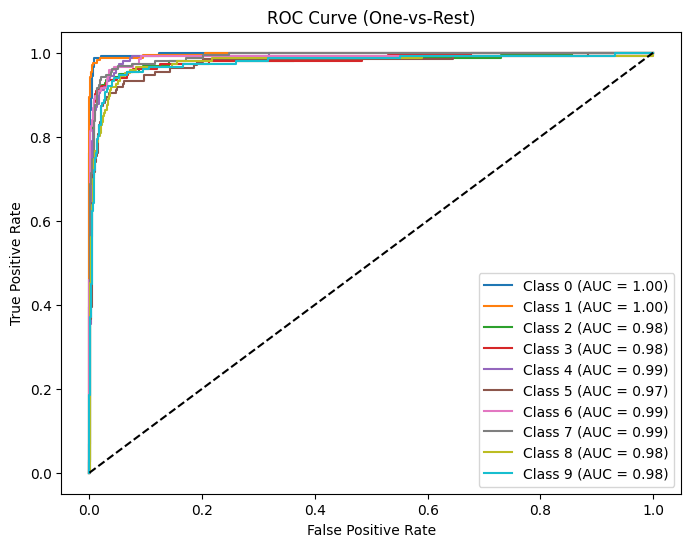

In [27]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# تحويل y_test إلى شكل ثنائي (one-hot)
y_test_bin = label_binarize(y_test, classes=[0,1,2,3,4,5,6,7,8,9])
n_classes = y_test_bin.shape[1]

# الحصول على احتمالات التوقع
y_proba = log_model.predict_proba(X_test_scaled)

# رسم ROC لكل فئة
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')  # خط عشوائي
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest)")
plt.legend(loc="lower right")
plt.show()

In [ ]:
from google.colab import files
files.download("mnist_test.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
# استدعاء المكتبات
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



In [38]:
from sklearn.svm import SVC

# إنشاء نموذج SVM خطي داخل Pipeline
# ----------------------------
svm_model = Pipeline([
    ('scaler', StandardScaler()),  # تطبيع البيانات: يجعل كل ميزة لها متوسط 0 وانحراف معياري 1
    ('classifier', SVC(kernel='linear',
                        C=1.0,
                        random_state=42,
                        probability=True))  # تمكين الاحتمالات لحساب ROC لاحقًا
])

In [47]:
svm_model = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', SVC(kernel='linear', C=1.0, random_state=42, probability=True))
])

In [30]:
# تدريب SVM على بيانات التدريب
svm_model.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 SVC(kernel='linear', probability=True, random_state=42))])

Accuracy: 0.9166666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98       147
           1       0.97      0.98      0.97       170
           2       0.90      0.92      0.91       155
           3       0.86      0.89      0.87       152
           4       0.91      0.94      0.93       147
           5       0.91      0.84      0.87       134
           6       0.95      0.94      0.94       144
           7       0.88      0.92      0.90       154
           8       0.94      0.89      0.91       146
           9       0.89      0.85      0.87       151

    accuracy                           0.92      1500
   macro avg       0.92      0.92      0.92      1500
weighted avg       0.92      0.92      0.92      1500



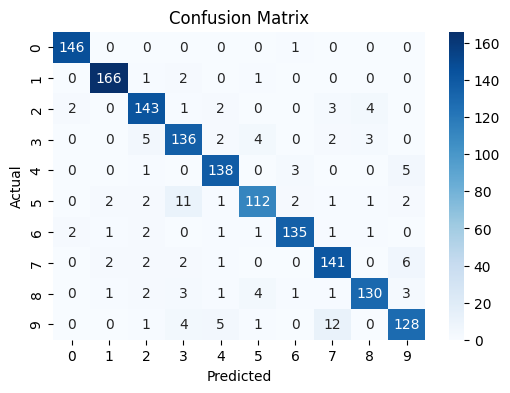

In [40]:
#  التنبؤ وتقييم النموذج
# ----------------------------

# Fit the SVM model on the training data before making predictions
svm_model.fit(X_train, y_train)

y_pred_svm = svm_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("\nClassification Report:\n", classification_report(y_test, y_pred_svm))

cm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [41]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
# تطبيع (تقييس) بيانات التدريب لجعل كل ميزة لها متوسط 0 وانحراف معياري 1
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)  # تطبيع البيانات
# إنشاء نموذج SVM بنواة RBF وضبط المعاملات C و gamma
svm_model = SVC(kernel='rbf', C=1.0, gamma='scale')
# استخدام 5-fold cross validation
scores = cross_val_score(svm_model, X_scaled, y_train, cv=5)
# طباعة نتائج كل تقسيمة والدقة المتوسطة للنموذج
print("Cross Validation Scores:", scores)
print("Average Accuracy:", scores.mean())

Cross Validation Scores: [0.93071429 0.93785714 0.925      0.94       0.92      ]
Average Accuracy: 0.9307142857142857


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


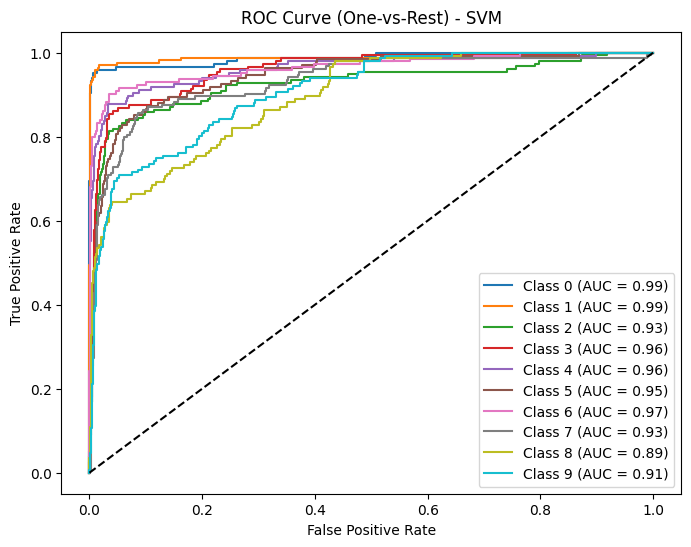

In [51]:

# التنبؤ بالاحتمالات
y_proba = svm_model.predict_proba(X_test_scaled)

# رسم ROC لكل فئة
plt.figure(figsize=(8,6))
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"Class {i} (AUC = {roc_auc:.2f})")

plt.plot([0,1], [0,1], 'k--')  # خط الأداء العشوائي
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve (One-vs-Rest) - SVM")
plt.legend(loc="lower right")
plt.show()